<a href="https://colab.research.google.com/github/tungnt28/Natural-Language-Processing/blob/main/nlp_final_exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Get data comment from Shopee**

In [ ]:
import re
import json
import requests
import pandas as pd

def get_cmt_from_shopee_url(url):

    r = re.search(r"i\.(\d+)\.(\d+)", url)
    shop_id, item_id = r[1], r[2]
    ratings_url = "https://shopee.vn/api/v2/item/get_ratings?filter=0&flag=1&itemid={item_id}&limit=50&offset={offset}&shopid={shop_id}&type={rating}"

    # d = {"username": [], "rating": [], "comment": []}
    d = {"comment": [], "rating": []}

    for rate in range(1, 6):
        offset = 0
        while True:
            try:
              data = requests.get(ratings_url.format(shop_id=shop_id, item_id=item_id, offset=offset, rating = rate)).json()

              i = 1
              for i, rating in enumerate(data["data"]["ratings"], 1):
                  d["rating"].append(rating["rating_star"])
                  d["comment"].append(rating["comment"])

                  # print(rating["rating_star"])
                  # print(rating["comment"])
                  # print("-" * 100)

              offset += 50
            except TypeError:
              break
    return d

In [ ]:
url = "https://shopee.vn/S%E1%BB%AFa-r%E1%BB%ADa-m%E1%BA%B7t-Simple-l%C3%A0nh-t%C3%ADnh-s%E1%BA%A1ch-tho%C3%A1ng-cho-da-nh%E1%BA%A1y-c%E1%BA%A3m-150ml-CH%C3%8DNH-H%C3%83NG-%C4%90%E1%BB%98C-QUY%E1%BB%80N-DI%E1%BB%86N-M%E1%BA%A0O-M%E1%BB%9AI--i.111138057.8587034871"
df = pd.DataFrame(get_cmt_from_shopee_url(url))
df

,comment,rating
0,Công dụng:rỬa mặt\nMùi hương:ổn\nKết cấu:gel\n...,1
1,Công dụng:sữa rửa mặt\nMùi hương:chưa biết\nDà...,1
2,Dành cho da:lhuf hợp với mọi loại da\nCông dụn...,1
3,Công dụng:Rửa mặt\nMùi hương:Gần như không có\...,1
4,Công dụng:làm sạch\nMùi hương:không biết\nDành...,1
...,...,...
11263,Công dụng:làm sạch bề da mặt\nMùi hương:không ...,5
11264,Công dụng:lamf sạch da\nMùi hương:thơm dịu\nDà...,5
11265,"Nhận hàng, cảm nhận quá tuyệt vời luôn ạ! Shop...",5
11266,Dành cho da:nhạy cảm\nMùi hương:nhẹ\nCông dụng...,5


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df.to_csv("/content/drive/MyDrive/Colab Notebooks/shopee_data_final.csv", index=False)

In [201]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11268 entries, 0 to 11267
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  11268 non-null  object
 1   rating   11268 non-null  int64 
 2   words    11268 non-null  object
 3   label    11268 non-null  object
 4   feature  11268 non-null  object
dtypes: int64(1), object(4)
memory usage: 440.3+ KB


# Xử lý dữ liệu

In [ ]:
num_words = 11268

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from scipy.spatial.distance import cdist

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
! pip install underthesea==6.6.0
! pip install stop-words

**Chuẩn hóa dữ liệu tiếng việt, tách từ**

In [ ]:
from underthesea import sent_tokenize
from underthesea import text_normalize
from underthesea import word_tokenize

In [ ]:
from stop_words import get_stop_words
from nltk.tokenize import RegexpTokenizer

stop_words = get_stop_words('vi')

def remove_vietnamese_stopwords(words):
  filtered_words = [word for word in words if word.lower() not in stop_words]
  return ' '.join(filtered_words)

def assign_label(rating):
  new_class = "neutral"
  if rating>=4:
    new_class = "positive"
  elif rating<=2:
    new_class = "negative"
  return new_class

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')
df['words'] = df['comment'].apply(tokenizer.tokenize)
df['words'] = df['words'].apply(remove_vietnamese_stopwords)
df['label'] = df['rating'].apply(assign_label)
df.head(5)

,comment,rating,words,label
0,Công dụng:rỬa mặt\nMùi hương:ổn\nKết cấu:gel\n...,1,Công dụng rỬa mặt Mùi hương ổn Kết cấu gel sho...,negative
1,Công dụng:sữa rửa mặt\nMùi hương:chưa biết\nDà...,1,Công dụng sữa rửa mặt Mùi hương da bình chất v...,negative
2,Dành cho da:lhuf hợp với mọi loại da\nCông dụn...,1,da lhuf hợp da Công dụng sạch da Mùi hương mùi...,negative
3,Công dụng:Rửa mặt\nMùi hương:Gần như không có\...,1,Công dụng Rửa mặt Mùi hương da da Shipper gọi ...,negative
4,Công dụng:làm sạch\nMùi hương:không biết\nDành...,1,Công dụng sạch Mùi hương da tất flashs sale 1 ...,negative


label
positive    6100
negative    3169
neutral     1999
Name: count, dtype: int64


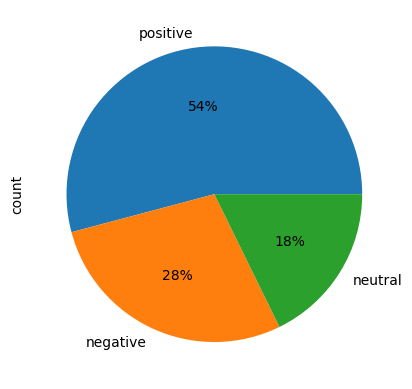

In [ ]:
import matplotlib.pyplot as plt
countClass = pd.value_counts(df['label'], sort=True, dropna=False)
print(countClass)
countClass.plot(kind = "pie", autopct= '%1.0f%%')
plt.show()

**Load data**

In [ ]:
def create_word_features(clean_words):
    my_dict = dict([(word, True) for word in clean_words])
    return my_dict

df['feature'] = df['words'].apply(create_word_features)

In [192]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Convert text data into bag-of-words features
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(df['words'])

# Split the data into training and testing sets
x_train_text, x_test_text, y_train, y_test = train_test_split(x, df['words'], test_size= 0.2, random_state = 42)

In [193]:
# Convert to numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

In [202]:
# Conver to numpy arrays
x_train_text = np.array(x_train_text)
x_test_text = np.array(x_test_text)

In [203]:
print (x_test_text[1])

Kết cấu típ Công dụng rữa mặt Mùi hương hơi hôi hàng giả hya j mn nắp vận nhìu bọt lắm nhìu hơi hôi


In [204]:
print (x_train_text[1])

Sản phẩm giao đóng gói cẩn thận hình Nắp ko đóng Cảm giác srm k sạch lắm


In [208]:
print("Train-set size: ", len(x_train_text))
print("Test-set size:  ", len(x_test_text))

Train-set size:  9014
Test-set size:   2254


In [210]:
x_train_text[1]

'Sản phẩm giao đóng gói cẩn thận hình Nắp ko đóng Cảm giác srm k sạch lắm'

**Tokenization**


In [211]:
num_words = 10000000

In [212]:
tokenizer = Tokenizer(num_words=num_words)

In [213]:
%%time
tokenizer.fit_on_texts(df['comment'])

CPU times: user 492 ms, sys: 6.43 ms, total: 499 ms
Wall time: 522 ms


In [214]:
if num_words is None:
    num_words = len(tokenizer.word_index)

In [ ]:
tokenizer.word_index

In [216]:
x_train_tokens = tokenizer.texts_to_sequences(x_train_text)

In [217]:
x_train_text[1]

'Sản phẩm giao đóng gói cẩn thận hình Nắp ko đóng Cảm giác srm k sạch lắm'

In [218]:
np.array(x_train_tokens[1])

array([ 33,  31,  14,  22,  16,  76,  77, 105, 149,  20,  22,  35, 253,
        68,  25,  23,  66])

In [219]:
x_test_tokens = tokenizer.texts_to_sequences(x_test_text)

Padding and Truncating Data

In [220]:
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]
num_tokens = np.array(num_tokens)

The average number of tokens in a sequence is:

In [221]:
np.mean(num_tokens)

15.620962016329429

The maximum number of tokens in a sequence is:

In [222]:
np.max(num_tokens)

329

The max number of tokens we will allow is set to the average plus 2 standard deviations.

In [223]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

41

In [ ]:
This covers about 95% of the data-set.

In [224]:
np.sum(num_tokens < max_tokens) / len(num_tokens)

0.9751508697195598

When padding or truncating the sequences that have a different length, we need to determine if we want to do this padding or truncating 'pre' or 'post'. If a sequence is truncated, it means that a part of the sequence is simply thrown away. If a sequence is padded, it means that zeros are added to the sequence.

So the choice of 'pre' or 'post' can be important because it determines whether we throw away the first or last part of a sequence when truncating, and it determines whether we add zeros to the beginning or end of the sequence when padding. This may confuse the Recurrent Neural Network.

In [225]:
pad = 'pre'

In [226]:
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens,
                            padding=pad, truncating=pad)

In [227]:
x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens,
                           padding=pad, truncating=pad)

We have now transformed the training-set into one big matrix of integers (tokens) with this shape:

In [228]:
x_train_pad.shape

(9014, 41)

The matrix for the test-set has the same shape:

In [229]:
x_test_pad.shape


(2254, 41)

In [231]:
np.array(x_train_tokens[1])

array([ 33,  31,  14,  22,  16,  76,  77, 105, 149,  20,  22,  35, 253,
        68,  25,  23,  66])

This has simply been padded to create the following sequence. Note that when this is input to the Recurrent Neural Network, then it first inputs a lot of zeros. If we had padded 'post' then it would input the integer-tokens first and then a lot of zeros. This may confuse the Recurrent Neural Network.

In [232]:
x_train_pad[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  33,  31,
        14,  22,  16,  76,  77, 105, 149,  20,  22,  35, 253,  68,  25,
        23,  66], dtype=int32)

##Tokenizer Inverse Map

In [233]:
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

In [234]:
def tokens_to_string(tokens):
    # Map from tokens back to words.
    words = [inverse_map[token] for token in tokens if token != 0]

    # Concatenate all words.
    text = " ".join(words)

    return text

In [235]:
x_train_text[1]

'Sản phẩm giao đóng gói cẩn thận hình Nắp ko đóng Cảm giác srm k sạch lắm'

In [236]:
tokens_to_string(x_train_tokens[1])

'sản phẩm giao đóng gói cẩn thận hình nắp ko đóng cảm giác srm k sạch lắm'

##Create the Recurrent Neural Network

In [237]:
model = Sequential()

In [238]:
embedding_size = 8

The embedding-layer also needs to know the number of words in the vocabulary (num_words) and the length of the padded token-sequences (max_tokens). We also give this layer a name because we need to retrieve its weights further below.

In [239]:
model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    input_length=max_tokens,
                    name='layer_embedding'))

We can now add the first Gated Recurrent Unit (GRU) to the network. This will have 16 outputs. Because we will add a second GRU after this one, we need to return sequences of data because the next GRU expects sequences as its input.

In [240]:
model.add(GRU(units=16, return_sequences=True))

In [242]:
model.add(GRU(units=8, return_sequences=True))

In [243]:
model.add(GRU(units=4))

In [244]:
model.add(Dense(1, activation='sigmoid'))

In [245]:
optimizer = Adam(lr=1e-3)

In [246]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [247]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_embedding (Embedding  (None, 41, 8)             80000000  
 )                                                               
                                                                 
 gru (GRU)                   (None, 41, 16)            1248      
                                                                 
 gru_1 (GRU)                 (None, 41, 8)             624       
                                                                 
 gru_2 (GRU)                 (None, 41, 8)             432       
                                                                 
 gru_3 (GRU)                 (None, 4)                 168       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                        

##Train the Recurrent Neural Network


We can now train the model. Note that we are using the data-set with the padded sequences. We use 5% of the training-set as a small validation-set, so we have a rough idea whether the model is generalizing well or if it is perhaps over-fitting to the training-set.

In [ ]:
%%time
model.fit(x_train_pad, y_train,
          validation_split=0.05, epochs=3, batch_size=64)